C:\Users\Shadow\AppData\Local\Temp\ipykernel_25236\4235381919.py:9: DtypeWarning: Columns (8,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Contamination: 0.01, Number of anomalies detected: 178
Contamination: 0.02, Number of anomalies detected: 356
Contamination: 0.03, Number of anomalies detected: 533
Contamination: 0.04, Number of anomalies detected: 711
Contamination: 0.05, Number of anomalies detected: 889
Contamination: 0.060000000000000005, Number of anomalies detected: 1066
Contamination: 0.06999999999999999, Number of anomalies detected: 1244
Contamination: 0.08, Number of anomalies detected: 1422
Contamination: 0.09, Number of anomalies detected: 1599
Contamination: 0.09999999999999999, Number of anomalies detected: 1777
Contamination: 0.11, Number of anomalies detected: 1954
Contamination: 0.12, Number of anomalies detected: 2132
Contamination: 0.13, Number of anomalies detected: 2310
Contamination: 0.14, Number of anomalies detected: 2487
Contamination: 0.15000000000000002, Number of anomalies detected: 2665
Contamination: 0.16, Number of anomalies detected: 2843
Contamination: 0.17, Number of anomalies detecte

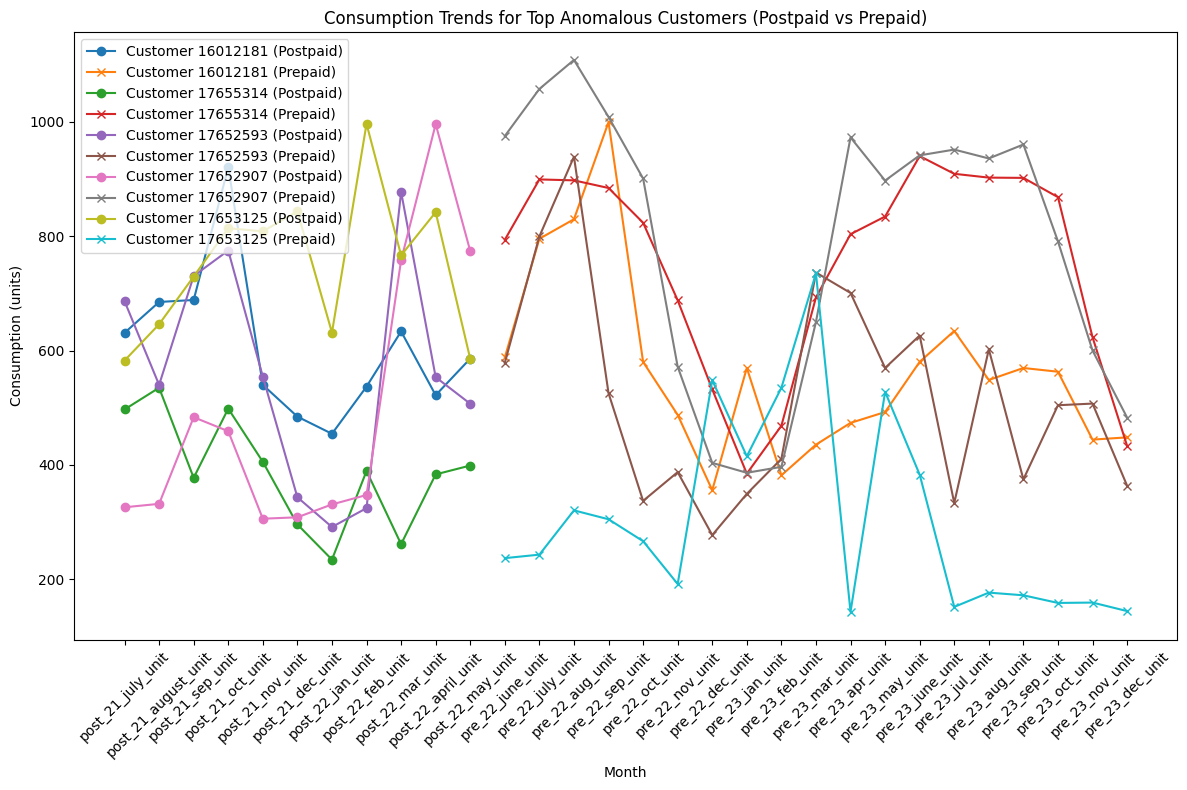

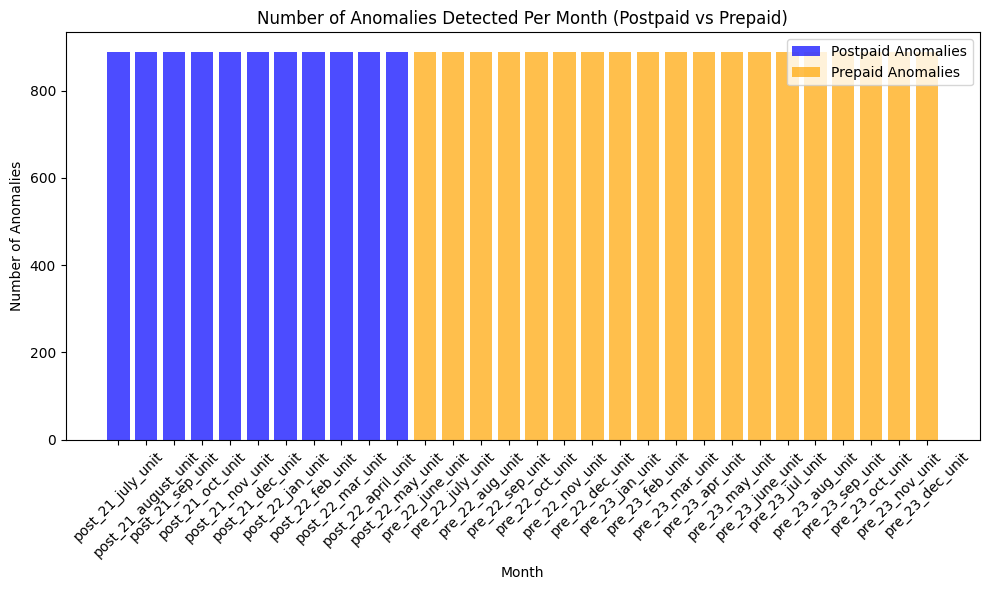

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns
import numpy as np


file_path = 'dataset.csv'  
data = pd.read_csv(file_path)

# Define postpaid and prepaid column names
postpaid_columns = [col for col in data.columns if 'post_' in col]
prepaid_columns = [col for col in data.columns if 'pre_' in col]

# Convert relevant columns to numeric and handle errors
data[postpaid_columns + prepaid_columns] = data[postpaid_columns + prepaid_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with excessive NaNs (optional thresholding to remove rows with too many missing values)
threshold = int(len(postpaid_columns + prepaid_columns) * 0.5)
data_cleaned = data.dropna(thresh=threshold)

# Select consumption-related columns for anomaly detection (postpaid and prepaid months)
consumption_data = data_cleaned[postpaid_columns + prepaid_columns]

# Handle missing values by filling with the median value (before applying rolling avg)
consumption_data = consumption_data.fillna(consumption_data.median())

# Apply rolling average with a window size of 2 months to smooth short-term variations
window_size = 2  # Adjust based on how much smoothing you want
data_cleaned[postpaid_columns] = data_cleaned[postpaid_columns].rolling(window=window_size, min_periods=1).mean()
data_cleaned[prepaid_columns] = data_cleaned[prepaid_columns].rolling(window=window_size, min_periods=1).mean()

# Fill the remaining NaNs in the smoothed data with median (after rolling average)
data_cleaned[postpaid_columns + prepaid_columns] = data_cleaned[postpaid_columns + prepaid_columns].fillna(data_cleaned.median())


# Generate contamination levels from 0.01 to 0.20 (1% to 20%)
contamination_values = np.linspace(0.01, 0.40, 40)

# Try different contamination levels
for contamination in contamination_values:
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest.fit(data_cleaned[postpaid_columns + prepaid_columns])
    anomaly_labels = iso_forest.predict(data_cleaned[postpaid_columns + prepaid_columns])
    anomaly_scores = iso_forest.decision_function(data_cleaned[postpaid_columns + prepaid_columns])
    data_cleaned['anomaly_label'] = anomaly_labels
    num_anomalies = sum(anomaly_labels == -1)
    print(f"Contamination: {contamination}, Number of anomalies detected: {num_anomalies}")

# Initialize Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model to the smoothed and cleaned consumption data
iso_forest.fit(data_cleaned[postpaid_columns + prepaid_columns])

# Predict anomalies (-1 indicates anomaly, 1 indicates normal)
anomaly_labels = iso_forest.predict(data_cleaned[postpaid_columns + prepaid_columns])

# Calculate anomaly scores (lower scores are more likely to be anomalies)
anomaly_scores = iso_forest.decision_function(data_cleaned[postpaid_columns + prepaid_columns])

# Add anomaly labels and scores to the cleaned dataset
data_cleaned['anomaly_label'] = anomaly_labels
data_cleaned['anomaly_score'] = anomaly_scores

# Summarize the number of anomalies detected
num_anomalies = sum(anomaly_labels == -1)
print(f"Number of anomalies detected: {num_anomalies}")

# Distribution of anomaly scores
print(data_cleaned['anomaly_score'].describe())

# Save full data with both anomalies and normal data to a CSV file
data_cleaned.to_csv('RA+IF_full_data_with_anomalies.csv', index=False)  # All customers including anomaly labels

# Save only the normal customers (anomaly_label = 1)
normal_customers = data_cleaned[data_cleaned['anomaly_label'] == 1]
normal_customers.to_csv('RA+IF_normal_customers.csv', index=False)  # Normal customers saved here

# Identifying customers who are flagged as anomalous most frequently
anomalous_data = data_cleaned[data_cleaned['anomaly_label'] == -1]
anomaly_frequencies = anomalous_data.groupby('Customer No')['anomaly_label'].count()

# Sort customers by frequency of anomalies
frequent_anomalies = anomaly_frequencies.sort_values(ascending=False)

# Extract top 5 anomalous customers
top_customers = frequent_anomalies.head(5).index
top_customers_data = data_cleaned[data_cleaned['Customer No'].isin(top_customers)]

# Plot consumption trends for the top 5 anomalous customers (using smoothed data)
plt.figure(figsize=(12, 8))
for customer in top_customers:
    customer_data = top_customers_data[top_customers_data['Customer No'] == customer]
    plt.plot(postpaid_columns, customer_data[postpaid_columns].values.flatten(), label=f'Customer {customer} (Postpaid)', marker='o')
    plt.plot(prepaid_columns, customer_data[prepaid_columns].values.flatten(), label=f'Customer {customer} (Prepaid)', marker='x')

plt.title('Consumption Trends for Top Anomalous Customers (Postpaid vs Prepaid)')
plt.xlabel('Month')
plt.ylabel('Consumption (units)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('RA+IF_Consumption Trends for Top Anomalous Customers (Postpaid vs Prepaid).png', dpi=300)
plt.show()

# Anomalies per month for postpaid and prepaid periods
anomalies_per_month_postpaid = anomalous_data[postpaid_columns].notna().sum()
anomalies_per_month_prepaid = anomalous_data[prepaid_columns].notna().sum()

# Plotting the number of anomalies per month
plt.figure(figsize=(10, 6))
plt.bar(postpaid_columns, anomalies_per_month_postpaid, label='Postpaid Anomalies', alpha=0.7, color='blue')
plt.bar(prepaid_columns, anomalies_per_month_prepaid, label='Prepaid Anomalies', alpha=0.7, color='orange')
plt.xticks(rotation=45)
plt.title('Number of Anomalies Detected Per Month (Postpaid vs Prepaid)')
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.legend()
plt.tight_layout()
plt.savefig('RA+IF_Number of Anomalies Detected Per Month (Postpaid vs Prepaid).png', dpi=300)
plt.show()

# Save anomalies to a CSV file 
anomalous_data.to_csv('RA+IF_anomalies_detected.csv', index=False)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = 'dataset.csv'  
data = pd.read_csv(file_path)

# Ensure 'Customer No' or similar identifier is present
if 'Customer No' not in data.columns:
    # If not present, you need to have a unique identifier for each customer
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Customer No'}, inplace=True)

# Identify postpaid and prepaid columns
postpaid_columns = [col for col in data.columns if 'post_' in col]
prepaid_columns = [col for col in data.columns if 'pre_' in col]

# Convert relevant columns to numeric
data[postpaid_columns + prepaid_columns] = data[postpaid_columns + prepaid_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with excessive NaNs
threshold = int(len(postpaid_columns + prepaid_columns) * 0.5)
data_cleaned = data.dropna(thresh=threshold)

# Initialize lists to store results
customer_anomalies = []
customer_normal = []

# Loop over each customer
for _, customer_data in data_cleaned.iterrows():
    customer_id = customer_data['Customer No']
    # Prepare data for Prophet
    def prepare_prophet_data(customer_series, columns, period):
        df = pd.DataFrame({
            'ds': pd.date_range(start='2020-01-01', periods=len(columns), freq='M'),
            'y': customer_series[columns].values
        })
        return df

    # Forecast for postpaid data
    if not customer_data[postpaid_columns].isnull().all():
        prophet_data_post = prepare_prophet_data(customer_data, postpaid_columns, 'postpaid')
        prophet_data_post.dropna(inplace=True)
        if len(prophet_data_post) > 2:  # Prophet requires at least two data points
            model_post = Prophet()
            model_post.fit(prophet_data_post)
            forecast_post = model_post.predict(prophet_data_post)
            residuals_post = prophet_data_post['y'] - forecast_post['yhat']
        else:
            residuals_post = pd.Series([0]*len(postpaid_columns))
    else:
        residuals_post = pd.Series([0]*len(postpaid_columns))

    # Forecast for prepaid data
    if not customer_data[prepaid_columns].isnull().all():
        prophet_data_pre = prepare_prophet_data(customer_data, prepaid_columns, 'prepaid')
        prophet_data_pre.dropna(inplace=True)
        if len(prophet_data_pre) > 2:
            model_pre = Prophet()
            model_pre.fit(prophet_data_pre)
            forecast_pre = model_pre.predict(prophet_data_pre)
            residuals_pre = prophet_data_pre['y'] - forecast_pre['yhat']
        else:
            residuals_pre = pd.Series([0]*len(prepaid_columns))
    else:
        residuals_pre = pd.Series([0]*len(prepaid_columns))

    # Combine residuals
    residuals_combined = pd.concat([residuals_post.reset_index(drop=True),
                                    residuals_pre.reset_index(drop=True)], ignore_index=True).fillna(0)

    # Reshape residuals for Isolation Forest
    residuals_combined = residuals_combined.values.reshape(-1, 1)

    # Fit Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(residuals_combined)

    # Predict anomalies
    anomaly_labels = iso_forest.predict(residuals_combined)
    anomaly_scores = iso_forest.decision_function(residuals_combined)

    # If any anomalies are detected for this customer, add to anomalies list
    if (anomaly_labels == -1).any():
        customer_anomalies.append({
            'Customer No': customer_id,
            'Residuals': residuals_combined.flatten(),
            'Anomaly Labels': anomaly_labels,
            'Anomaly Scores': anomaly_scores
        })
    else:
        customer_normal.append(customer_id)

# Convert anomalies list to DataFrame
anomalies_df = pd.DataFrame(customer_anomalies)

# Save anomalies to CSV
anomalies_df.to_csv('Prophet+IF_anomalies_detected.csv', index=False)

# Save normal customers to CSV
normal_customers_df = data_cleaned[data_cleaned['Customer No'].isin(customer_normal)]
normal_customers_df.to_csv('Prophet+IF_normal_customers.csv', index=False)

# Summarize the number of anomalies detected
num_anomalies = len(anomalies_df)
print(f"Number of customers with anomalies detected: {num_anomalies}")

# Identify top anomalous customers
anomalies_df['Total Anomalies'] = anomalies_df['Anomaly Labels'].apply(lambda x: sum(x == -1))
top_anomalous_customers = anomalies_df.sort_values('Total Anomalies', ascending=False).head(5)

# Visualization for Top Anomalous Customers
plt.figure(figsize=(12, 8))
for idx, row in top_anomalous_customers.iterrows():
    customer_id = row['Customer No']
    residuals = row['Residuals']
    anomaly_labels = row['Anomaly Labels']
    timestamps = range(len(residuals))

    plt.plot(timestamps, residuals, label=f'Customer {customer_id}', marker='o')
    anomaly_indices = [i for i, label in enumerate(anomaly_labels) if label == -1]
    plt.scatter([timestamps[i] for i in anomaly_indices],
                [residuals[i] for i in anomaly_indices], color='red')

plt.title('Residuals for Top Anomalous Customers')
plt.xlabel('Time Index')
plt.ylabel('Residuals (Actual - Forecast)')
plt.legend()
plt.tight_layout()
plt.savefig('Prophet+IF_Top_Anomalous_Customers.png', dpi=300)
plt.show()


16:43:41 - cmdstanpy - INFO - Chain [1] start processing
16:43:41 - cmdstanpy - INFO - Chain [1] done processing
16:43:41 - cmdstanpy - INFO - Chain [1] start processing
16:43:41 - cmdstanpy - INFO - Chain [1] done processing
16:43:41 - cmdstanpy - INFO - Chain [1] start processing
16:43:41 - cmdstanpy - INFO - Chain [1] done processing
16:43:41 - cmdstanpy - INFO - Chain [1] start processing
16:43:42 - cmdstanpy - INFO - Chain [1] done processing
16:43:42 - cmdstanpy - INFO - Chain [1] start processing
16:43:42 - cmdstanpy - INFO - Chain [1] done processing
16:43:42 - cmdstanpy - INFO - Chain [1] start processing
16:43:42 - cmdstanpy - INFO - Chain [1] done processing
16:43:42 - cmdstanpy - INFO - Chain [1] start processing
16:43:42 - cmdstanpy - INFO - Chain [1] done processing
16:43:42 - cmdstanpy - INFO - Chain [1] start processing
16:43:42 - cmdstanpy - INFO - Chain [1] done processing
16:43:42 - cmdstanpy - INFO - Chain [1] start processing
16:43:42 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from prophet import Prophet
import multiprocessing as mp
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -----------------------------
# Step 1: Load and Preprocess Data
# -----------------------------

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Ensure 'Customer No' or similar identifier is present
if 'Customer No' not in data.columns:
    # If not present, create a unique identifier for each customer
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Customer No'}, inplace=True)

# Identify postpaid and prepaid columns based on column naming
postpaid_columns = [col for col in data.columns if 'post_' in col]
prepaid_columns = [col for col in data.columns if 'pre_' in col]

# Convert relevant columns to numeric and handle errors
data[postpaid_columns + prepaid_columns] = data[postpaid_columns + prepaid_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with excessive NaNs (optional thresholding to remove rows with too many missing values)
threshold = int(len(postpaid_columns + prepaid_columns) * 0.5)
data_cleaned = data.dropna(thresh=threshold)

# -----------------------------
# Step 2: Define Functions
# -----------------------------

def prepare_prophet_data(customer_series, columns):
    """
    Prepare a DataFrame suitable for Prophet modeling for a single customer.
    """
    # Create a date range based on the number of periods
    start_date = '2020-01-01'  # Adjust as necessary
    df = pd.DataFrame({
        'ds': pd.date_range(start=start_date, periods=len(columns), freq='M'),
        'y': customer_series[columns].values
    })
    return df

def process_customer(customer_data):
    """
    Process data for a single customer: fit Prophet models and detect anomalies.
    """
    customer_id = customer_data['Customer No']
    results = {'Customer No': customer_id}

    # Prepare data for Prophet
    residuals_post = pd.Series(dtype='float64')
    residuals_pre = pd.Series(dtype='float64')

    # Forecast for postpaid data
    if not customer_data[postpaid_columns].isnull().all():
        prophet_data_post = prepare_prophet_data(customer_data, postpaid_columns)
        prophet_data_post.dropna(inplace=True)
        if len(prophet_data_post) > 2:
            # Simplify the Prophet model for faster computation
            model_post = Prophet(
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                n_changepoints=5,
                seasonality_mode='additive',
                mcmc_samples=0
            )
            model_post.fit(prophet_data_post)
            forecast_post = model_post.predict(prophet_data_post)
            residuals_post = prophet_data_post['y'] - forecast_post['yhat']
        else:
            residuals_post = pd.Series([0]*len(prophet_data_post), dtype='float64')
    else:
        residuals_post = pd.Series([0]*len(postpaid_columns), dtype='float64')

    # Forecast for prepaid data
    if not customer_data[prepaid_columns].isnull().all():
        prophet_data_pre = prepare_prophet_data(customer_data, prepaid_columns)
        prophet_data_pre.dropna(inplace=True)
        if len(prophet_data_pre) > 2:
            model_pre = Prophet(
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                n_changepoints=5,
                seasonality_mode='additive',
                mcmc_samples=0
            )
            model_pre.fit(prophet_data_pre)
            forecast_pre = model_pre.predict(prophet_data_pre)
            residuals_pre = prophet_data_pre['y'] - forecast_pre['yhat']
        else:
            residuals_pre = pd.Series([0]*len(prophet_data_pre), dtype='float64')
    else:
        residuals_pre = pd.Series([0]*len(prepaid_columns), dtype='float64')

    # Combine residuals
    residuals_combined = pd.concat([residuals_post.reset_index(drop=True),
                                    residuals_pre.reset_index(drop=True)], ignore_index=True).fillna(0)

    # Reshape residuals for Isolation Forest
    residuals_combined = residuals_combined.values.reshape(-1, 1)

    # Fit Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(residuals_combined)

    # Predict anomalies
    anomaly_labels = iso_forest.predict(residuals_combined)
    anomaly_scores = iso_forest.decision_function(residuals_combined)

    # Store results
    results.update({
        'Residuals': residuals_combined.flatten(),
        'Anomaly Labels': anomaly_labels,
        'Anomaly Scores': anomaly_scores
    })

    return results

# -----------------------------
# Step 3: Process Customers Using Multiprocessing
# -----------------------------

def main():
    # Prepare data for multiprocessing
    customer_list = [row for _, row in data_cleaned.iterrows()]

    # Use multiprocessing Pool
    pool = mp.Pool(processes=mp.cpu_count())
    results = pool.map(process_customer, customer_list)
    pool.close()
    pool.join()

    # Convert results to DataFrame
    anomalies_df = pd.DataFrame(results)

    # -----------------------------
    # Step 4: Analyze and Save Results
    # -----------------------------

    # Save anomalies to CSV
    anomalies_df.to_csv('Prophet+IF_anomalies_detected.csv', index=False)

    # Identify customers without anomalies
    anomalies_df['Total Anomalies'] = anomalies_df['Anomaly Labels'].apply(lambda x: sum(x == -1))
    all_customers = set(data_cleaned['Customer No'])
    anomalous_customers = set(anomalies_df['Customer No'])
    normal_customers = all_customers - anomalous_customers

    # Save normal customers to CSV
    normal_customers_df = data_cleaned[data_cleaned['Customer No'].isin(normal_customers)]
    normal_customers_df.to_csv('Prophet+IF_normal_customers.csv', index=False)

    # Summarize the number of anomalies detected
    num_anomalies = len(anomalies_df)
    print(f"Number of customers with anomalies detected: {num_anomalies}")

    # Identify top anomalous customers
    top_anomalous_customers = anomalies_df.sort_values('Total Anomalies', ascending=False).head(5)

    # -----------------------------
    # Step 5: Visualization
    # -----------------------------

    # Create directory for plots if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')

    # Visualization for Top Anomalous Customers
    plt.figure(figsize=(12, 8))
    for idx, row in top_anomalous_customers.iterrows():
        customer_id = row['Customer No']
        residuals = row['Residuals']
        anomaly_labels = row['Anomaly Labels']
        timestamps = range(len(residuals))

        plt.plot(timestamps, residuals, label=f'Customer {customer_id}', marker='o')
        anomaly_indices = [i for i, label in enumerate(anomaly_labels) if label == -1]
        plt.scatter([timestamps[i] for i in anomaly_indices],
                    [residuals[i] for i in anomaly_indices], color='red')

    plt.title('Residuals for Top Anomalous Customers')
    plt.xlabel('Time Index')
    plt.ylabel('Residuals (Actual - Forecast)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/Prophet+IF_Top_Anomalous_Customers.png', dpi=300)
    plt.show()

    # Plotting the number of anomalies per customer
    anomalies_df['Total Anomalies'] = anomalies_df['Anomaly Labels'].apply(lambda x: sum(x == -1))
    anomalies_df.sort_values('Total Anomalies', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    plt.bar(anomalies_df['Customer No'].astype(str), anomalies_df['Total Anomalies'])
    plt.title('Total Number of Anomalies Detected per Customer')
    plt.xlabel('Customer No')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('plots/Prophet+IF_Anomalies_Per_Customer.png', dpi=300)
    plt.show()

    # Save full data with both anomalies and normal data to a CSV file
    data_cleaned.to_csv('Prophet+IF_full_data_with_anomalies.csv', index=False)

if __name__ == '__main__':
    main()


Number of customers with anomalies detected: 17764


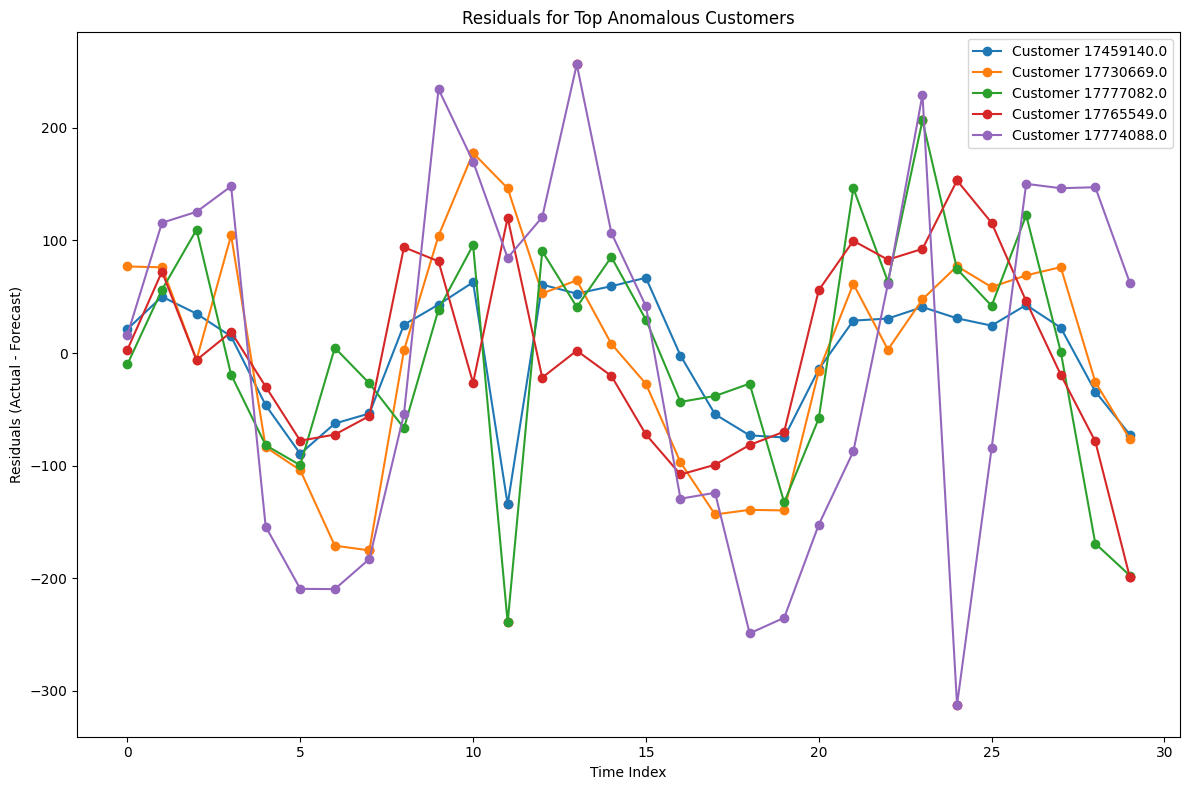

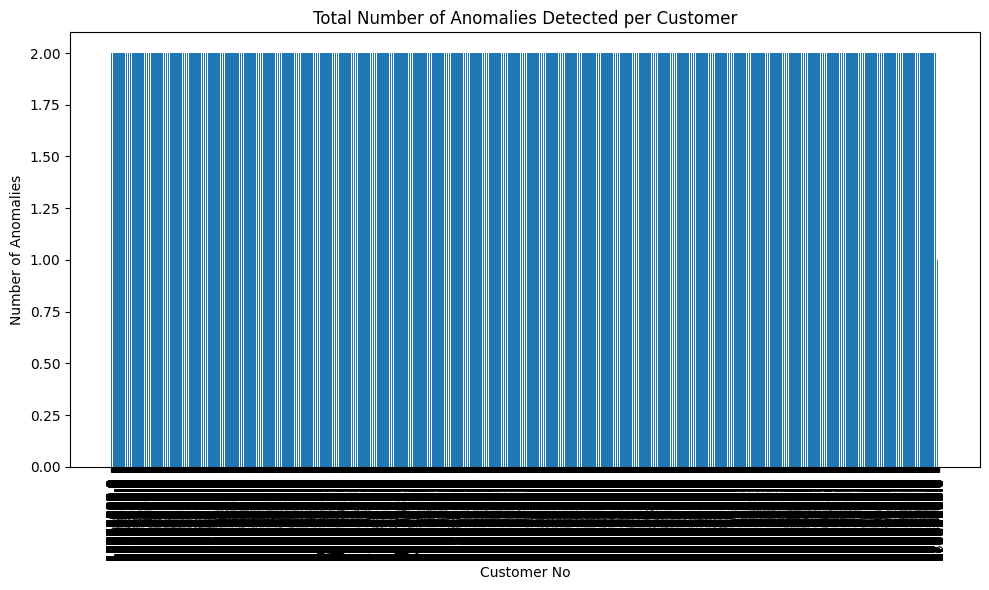

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from prophet import Prophet
from joblib import Parallel, delayed
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# -----------------------------
# Step 1: Load and Preprocess Data
# -----------------------------

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Ensure 'Customer No' or similar identifier is present
if 'Customer No' not in data.columns:
    # If not present, create a unique identifier for each customer
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Customer No'}, inplace=True)

# Identify postpaid and prepaid columns based on column naming
postpaid_columns = [col for col in data.columns if 'post_' in col]
prepaid_columns = [col for col in data.columns if 'pre_' in col]

# Convert relevant columns to numeric and handle errors
data[postpaid_columns + prepaid_columns] = data[postpaid_columns + prepaid_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with excessive NaNs (optional thresholding to remove rows with too many missing values)
threshold = int(len(postpaid_columns + prepaid_columns) * 0.5)
data_cleaned = data.dropna(thresh=threshold)

# -----------------------------
# Step 2: Define Functions
# -----------------------------

def prepare_prophet_data(customer_series, columns):
    """
    Prepare a DataFrame suitable for Prophet modeling for a single customer.
    """
    # Create a date range based on the number of periods
    start_date = '2020-01-01'  # Adjust as necessary
    df = pd.DataFrame({
        'ds': pd.date_range(start=start_date, periods=len(columns), freq='M'),
        'y': customer_series[columns].values
    })
    return df

def process_customer(customer_id, customer_data):
    """
    Process data for a single customer: fit Prophet models and detect anomalies.
    """
    # Prepare data for Prophet
    residuals_list = []

    # Process both postpaid and prepaid data
    for columns in [postpaid_columns, prepaid_columns]:
        # Ensure columns are present
        customer_columns = [col for col in columns if col in customer_data.index]
        if not customer_data[customer_columns].isnull().all():
            prophet_data = prepare_prophet_data(customer_data, customer_columns)
            prophet_data.dropna(inplace=True)
            if len(prophet_data) > 2:
                # Simplify the Prophet model for faster computation
                model = Prophet(
                    yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False,
                    n_changepoints=5,
                    seasonality_mode='additive',
                    mcmc_samples=0
                )
                model.fit(prophet_data)
                forecast = model.predict(prophet_data)
                residuals = prophet_data['y'] - forecast['yhat']
                residuals_list.extend(residuals)
            else:
                residuals_list.extend([0]*len(prophet_data))
        else:
            residuals_list.extend([0]*len(customer_columns))

    # Reshape residuals for Isolation Forest
    residuals_combined = pd.Series(residuals_list).fillna(0).values.reshape(-1, 1)

    # Fit Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_forest.fit(residuals_combined)

    # Predict anomalies
    anomaly_labels = iso_forest.predict(residuals_combined)
    anomaly_scores = iso_forest.decision_function(residuals_combined)

    # Store results
    results = {
        'Customer No': customer_id,
        'Residuals': residuals_combined.flatten().tolist(),
        'Anomaly Labels': anomaly_labels.tolist(),
        'Anomaly Scores': anomaly_scores.tolist(),
    }

    return results

# -----------------------------
# Step 3: Process Customers Using Joblib for Parallel Processing
# -----------------------------

def main():
    # Prepare data for parallel processing
    customer_list = [(row['Customer No'], row) for _, row in data_cleaned.iterrows()]

    # Number of CPU cores to use
    num_cores = os.cpu_count()

    # Use joblib's Parallel
    results = Parallel(n_jobs=num_cores)(
        delayed(process_customer)(customer_id, customer_data) for customer_id, customer_data in customer_list
    )

    # Convert results to DataFrame
    anomalies_df = pd.DataFrame(results)

    # -----------------------------
    # Step 4: Analyze and Save Results
    # -----------------------------

    # Save anomalies to CSV
    anomalies_df.to_csv('Prophet+IF_anomalies_detected.csv', index=False)

    # Identify customers without anomalies
    anomalies_df['Total Anomalies'] = anomalies_df['Anomaly Labels'].apply(lambda x: sum([1 for label in x if label == -1]))
    all_customers = set(data_cleaned['Customer No'])
    anomalous_customers = set(anomalies_df['Customer No'])
    normal_customers = all_customers - anomalous_customers

    # Save normal customers to CSV
    normal_customers_df = data_cleaned[data_cleaned['Customer No'].isin(normal_customers)]
    normal_customers_df.to_csv('Prophet+IF_normal_customers.csv', index=False)

    # Summarize the number of anomalies detected
    num_anomalies = len(anomalies_df)
    print(f"Number of customers with anomalies detected: {num_anomalies}")

    # Identify top anomalous customers
    top_anomalous_customers = anomalies_df.sort_values('Total Anomalies', ascending=False).head(5)

    # -----------------------------
    # Step 5: Visualization
    # -----------------------------

    # Create directory for plots if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')

    # Visualization for Top Anomalous Customers
    plt.figure(figsize=(12, 8))
    for idx, row in top_anomalous_customers.iterrows():
        customer_id = row['Customer No']
        residuals = row['Residuals']
        anomaly_labels = row['Anomaly Labels']
        timestamps = range(len(residuals))

        plt.plot(timestamps, residuals, label=f'Customer {customer_id}', marker='o')
        anomaly_indices = [i for i, label in enumerate(anomaly_labels) if label == -1]
        plt.scatter([timestamps[i] for i in anomaly_indices],
                    [residuals[i] for i in anomaly_indices], color='red')

    plt.title('Residuals for Top Anomalous Customers')
    plt.xlabel('Time Index')
    plt.ylabel('Residuals (Actual - Forecast)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('plots/Prophet+IF_Top_Anomalous_Customers.png', dpi=300)
    plt.show()

    # Plotting the number of anomalies per customer
    anomalies_df.sort_values('Total Anomalies', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    plt.bar(anomalies_df['Customer No'].astype(str), anomalies_df['Total Anomalies'])
    plt.title('Total Number of Anomalies Detected per Customer')
    plt.xlabel('Customer No')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('plots/Prophet+IF_Anomalies_Per_Customer.png', dpi=300)
    plt.show()

    # Save full data with both anomalies and normal data to a CSV file
    data_cleaned.to_csv('Prophet+IF_full_data_with_anomalies.csv', index=False)

if __name__ == '__main__':
    main()
